# Neural & Behavioral Modeling - Week 16 (Exercises)
by Ting-Yu, Lin (tylin.amice@gmailc.om)

In [1]:
%config IPCompleter.greedy=True 
%matplotlib inline
from matplotlib.pyplot import *
from IPython.display import *
import numpy as np

## 1 Integrate-and-Fire Neuron with A Refractory Period (5 points)

Please modify the leaky integrate-and-fire model to produce the following dynamics showing <a href="https://en.wikipedia.org/wiki/Refractory_period_(physiology)">refractory/inactivation periods</a> like the following:

<img src="https://courses.cit.cornell.edu/ece5990/ECE5725_Fall2017_projects/aj373_ssd56_website/images/centerLED.png" width=70%>

Unlike the above figure, you need to produce "spikes" in your implementation.

### 1.0 The Leaky Integrate-and-Fire Model

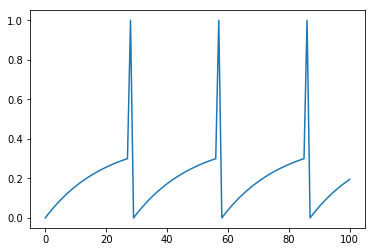

In [2]:
I=2;g=5;C=10;Vrst=0;Vthr=.3;Vspk=1;

dt=.1; V=[Vrst];

for t in np.arange(0,10,dt):
    V1=V[-1] # the last element
    s=V1>Vthr; # An implicit IF-THEN hack
    V2=s*Vrst+(1-s)*(V1+dt/C*(-g*V1+I)) # Euler integration
    V1=s*Vspk+(1-s)*V1 # Spiking now?
    V[-1]=V1; V.append(V2)

plot(V);

### 1.1 Your modified I-F model

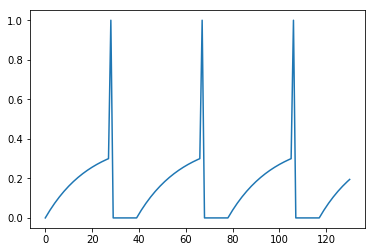

In [3]:
# Please write your codes here.
I=2;g=5;C=10;Vrst=0;Vthr=.3;Vspk=1;

dt=.1; V=[Vrst];
rest = 10

for t in np.arange(0,10,dt):
    V1=V[-1] # the last element
    s=V1>Vthr; # An implicit IF-THEN hack
    V2=s*Vrst+(1-s)*(V1+dt/C*(-g*V1+I)) # Euler integration
    V1=s*Vspk+(1-s)*V1 # Spiking now?
    V[-1]=V1; V.append(V2)
    if s:
        for res in np.arange(0,rest):
            V.append(0)

plot(V);

## 2 The Hodgkin–Huxley Model (5 points)
Please read P.19, P.20, & P.21 of the article by <a href="https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1392413/pdf/jphysiol01442-0106.pdf">Hodgkin & Huxley (1952)</a>
to implement the very original Hodgkin–Huxley model using their equations and parameters.

### 2.0 Modern implementation of the H-H model

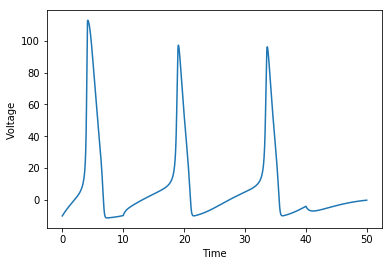

In [4]:
# Integration of Hodgkin--Huxley equations with Euler method
g=np.array([36, 120, 0.3]) # Maximal conductances (in units of mS/cm^2); 1=K, 2=Na, 3=l
E=np.array([-12, 115, 10.613]) # Resting potentials (in mV):
# Some initializations: some variables
gnmh=np.zeros(3); Alpha=np.zeros(3); Beta=np.zeros(3); x=np.zeros(3); 
x[2]=1; I_ext=0; V=[-10]; dt=0.01; 

tspan=np.arange(0,50,dt)
for t in tspan:
    
    V1=V[-1] # the last element
    if(t>=10 and t<=40):
        I_ext=10  # turns external current on when t=[10,40]
    else:  
        I_ext=0   
        
  # alpha functions:
    Alpha[0]=0.01*(10-V1)/(np.exp((10-V1)/10)-1)
    Alpha[1]=0.1*(25-V1)/(np.exp((25-V1)/10)-1)
    Alpha[2]=0.07*np.exp(-V1/20)
    
  # beta functions:
    Beta[0]=0.125*np.exp(-V1/80)
    Beta[1]=4*np.exp(-V1/18)
    Beta[2]=1/(np.exp((30-V1)/10)+1)
    
  # tau_x and x_0 (x=0,1,2) are defined with alpha and beta
    tau=1/(Alpha+Beta);
    x_inf=Alpha*tau;
    x=x+dt*(x_inf-x)/tau;
    
  # calculate actual conductances g with given n, m, h
    gnmh[0]=g[0]*x[0]**4;
    gnmh[1]=g[1]*x[1]**3*x[2];
    gnmh[2]=g[2];
    
  # Ohm's law
    I=gnmh*(V1-E);
    V2=V1+dt*(I_ext-sum(I))
    V.append(V2)
    
plot(tspan,V[:-1]); 
xlabel('Time'); ylabel('Voltage');

### 2.1 Your implementation of the original H-H model

<b>Discuss with 李達</b><br>
ref: https://gist.github.com/slarson/37463b35ef8606629d2e <br>


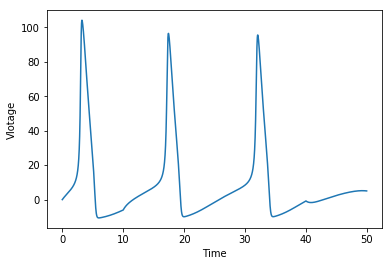

In [66]:
# Please write your codes here.
import scipy as sp
import pylab as plt
from scipy.integrate import odeint
from scipy import stats
import scipy.linalg as lin

## Full Hodgkin-Huxley Model
# Constants
C_m = 1 # membrane capacitance

# potentials
V_K = 12
V_Na = -115 
V_L = -10.613

#conducances
g_K = 36 
g_Na = 120 
g_L =  0.3 



# Functions of membrane voltage
def alpha_n(V):
    return 0.01*(V+10)/((sp.exp((V+10)/10)-1))
def beta_n(V):
    return 0.125*sp.exp(V/80)
def alpha_m(V):
    return 0.1*(V+25)/((sp.exp((V+25)/10)-1))
def beta_m(V):
    return 4*sp.exp(V/18)
def alpha_h(V):
    return 0.07*sp.exp(V/20)
def beta_h(V):
    return 1/((sp.exp((V+30)/10)+1))


# Membrane currents terms
def I_K(V, n):
    return g_K * n**4 * (V - V_K)
#     return g_K * np.power(n, 4.0) * (V - V_K)

def I_Na(V,m,h):
    #return g_Na * m**3 * h * (V - V_Na)
    return g_Na * m**3 * h * (V - V_Na)

def I_L(V): 
    return g_L* (V - V_L)


#initial value
#equation from 16_examples
def n_init(V):
    return alpha_n(V) / (alpha_n(V) + beta_n(V))
def m_init(V):
    return alpha_m(V) / (alpha_m(V) + beta_m(V))
def h_init(V):
    return alpha_h(V) / (alpha_h(V) + beta_h(V))

    
# External current
def I_inj(t):
    if(t>=10 and t<=40):
        I_ext=-10  # turns external current on when t=[10,40]
    else:  
        I_ext=-5
    return I_ext

# The time to integrate over
dt = 0.01
t = sp.arange(0, 50, dt)

def dAlldt(y, t0):
    results = np.zeros((4,))
    V = y[0]
    n = y[1]
    m = y[2]
    h = y[3]

    #dV/dt
    results[0] = (I_inj(t0)  - I_K(V,n)  - I_Na(V,m,h)  - I_L(V) )/C_m
    #dn/dt
    results[1] = (alpha_n(V) * (1 - n)) - (beta_n(V) * n)
    #dm/dt
    results[2] = (alpha_m(V) * (1 - m)) - (beta_m(V) * m)
    #dh/dt
    results[3] = (alpha_h(V) * (1 - h)) - (beta_h(V) * h)
    return results

#solve equation
X = odeint(dAlldt, [0, n_init(0), m_init(0), h_init(0)], t)


# plot 
plot(t, -X[:,0])
xlabel('Time');
ylabel('Vlotage');
